# Imports

In [1]:
import sys 
sys.path.append("/home/jovyan/work/notebooks/satellite_data/SA_segmentation/")
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.nn import DataParallel
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random

from pytorch_segmentation.data.train_dataset import TrainDataset
from pytorch_segmentation.data.inmemory_dataset import InMemorySatDataset
from pytorch_segmentation.train_net import train
from pytorch_segmentation.models import UNet
from pytorch_segmentation.losses.dice import DiceLoss
from pytorch_segmentation.losses.tversky import TverskyLoss
from pytorch_segmentation.losses.dice_V2 import FocalTversky_loss
import pytorch_segmentation.augmentation.transforms as seg_transforms
from pytorch_segmentation.losses.bce_pixel_weights import CrossEntropyWithPixelWeights

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:
cfg = {
    #SA high resoluted data
    "shape_path_sa_high": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/data_pool/SA_tree_shapes/labels.geojson",
    "train_data_path_sa_high": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/train/SA_high",
    "val_data_path_sa_high": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/val/SA_high",
    "test_data_path_sa_high": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/test/SA_high",

    #SA low data
    "shape_path_sa_low": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/data_pool/SA_tree_shapes/labels.geojson",
    "train_data_path_sa_low": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/train/SA_low",
    "val_data_path_sa_low": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/val/SA_low",
    "test_data_path_sa_low": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/test/SA_low",
    
    
    #Rwanda data 2008
    "shape_path_rw_2008": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/data_pool/rwanda_tree_shapes/Training_Data_Rwanda_high_res.geojson",
    "train_data_path_rw_2008": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/train/rwanda_2008",
    "val_data_path_rw_2008": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/val/rwanda_2008",
    "test_data_path_rw_2008": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/test/rwanda_2008",

    #Rwanda data 2019
    "shape_path_rw_2019": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/data_pool/rwanda_tree_shapes/Training_Data_Rwanda_low_res.geojson",
    "train_data_path_rw_2019": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/train/rwanda_2019",
    "val_data_path_rw_2019": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/val/rwanda_2019",
    "test_data_path_rw_2019": "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/datasets/V29/test/rwanda_2019",


    "tensorboard_path": "/home/jovyan/work/notebooks/runs",

    # patch_size = [364,364,3]# [x,y,bands]
    # overlap = 300

    # patch_size = [321,321,3]# [x,y,bands]
    # overlap = 270


    "patch_size": [300,300],# [x,y,bands]
    "overlap": 260,

    "val_patch_size": [256,256],# [x,y,bands]
    "val_overlap": 200,

    "test_patch_size": [256,256],
    "overlap_test": 128,

    "padding": False,#True

    "epochs": 500,#25

    "early_stopping": None,

    "dropout": True,

    "scheduler": False,
    "scheduler_warmup": 20,#10
    "sched_step": 15,
    "sched_gamma": 0.1,

    #batch_size = 200
    #batch_size = 50
    "batch_size": 50, #50 #150 #75

    "lr": 3e-4, #1e-3,
    "weight_decay": 1e-4, #1e-3,

    "weighted": True,
    "weight": 0.1,
    "sampler_replacement": True,

    "metric": "iou",

    "n_channels": 3,

    "nworkers": 4,
    "pin_memory": True,

    "nimgs": 7,
    "figsize": (24,21),
    
    "loss_fn": CrossEntropyWithPixelWeights(weights=[1,2])#nn.CrossEntropyLoss()#weight=torch.Tensor([0.25,4.]).to(torch.device("cuda:1"))) #TverskyLoss(0.3,0.7) 
}

In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

save_dir = "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/saved_models"




transform_sa_high = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(0.5,1)), #scale=(0.5,1)
        #seg_transforms.Add_VDVI(),
        seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.3),saturation=0.2),
        
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        #seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ]
    ,p=1),
    seg_transforms.CenterCrop(256)
])

transform_sa_low = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(1.25,1.5)), #scale=(1,1)
        #seg_transforms.Add_VDVI(),
        #seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.3),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        #seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ],p=1),
    seg_transforms.CenterCrop(256)
])

transform_rw_2008 = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(0.5,1)), #scale=(0.5,1)
        #seg_transforms.Add_VDVI(),
        #seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.3),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        #seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ]
    ,p=1),
    seg_transforms.CenterCrop(256)
])


transform_rw_2019 = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(1.25,1.5)), #scale=(1,1)
        #seg_transforms.Add_VDVI(),
        #seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.3),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        #seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ]
    ,p=1),
    seg_transforms.CenterCrop(256)
])


val_transform= None

val_transform_low = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    # seg_transforms.RandomHorizontalFlip(0.5),
    # seg_transforms.RandomVerticalFlip(0.5),
    #seg_transforms.UnmaskEdges([225,225])
#         seg_transforms.Normalize(mean=[0.5492, 0.5190, 0.4393],
#                                          std=[0.1381, 0.1320, 0.1349])
    seg_transforms.Resize(320),
    seg_transforms.CenterCrop(256),
])

test_transform = None


# 1.1 Data Collection

#### Create Training and Test Dataset - SA low

In [4]:
train_dataset_sa_low = TrainDataset(dataset_path=None,data_file_path=cfg["train_data_path_sa_low"],
                   shape_path=cfg["shape_path_sa_low"],tree_size_threshold=1,
                             overlap=cfg["overlap"],patch_size=cfg["patch_size"],padding=cfg["padding"],transform=transform_sa_low)
val_dataset_sa_low = TrainDataset(dataset_path=None,data_file_path=cfg["val_data_path_sa_low"],
                   shape_path=cfg["shape_path_sa_low"],tree_size_threshold=1,
                             overlap=cfg["val_overlap"],patch_size=cfg["val_patch_size"],padding=cfg["padding"],transform=val_transform_low)

# train_dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path_sa_train,
#                              overlap=overlap,patch_size=patch_size,padding=padding,transform=transform)
# val_dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path_sa_val,
#                              overlap=val_overlap,patch_size=val_patch_size,padding=padding,transform=val_transform)
# # test_dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path_sa_test,
#                              overlap=overlap_test,patch_size=test_patch_size,padding=padding,transform=test_transform)


print("Len Train: ",len(train_dataset_sa_low))
print("Len Val: ",len(val_dataset_sa_low))
#print("Len Test: ",len(test_dataset_sa))

  0%|          | 0/24 [00:00<?, ?it/s]/home/jovyan/work/notebooks/satellite_data/SA_segmentation/pytorch_segmentation/data/train_dataset.py:194: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  big_trees= shape_df_filter[shape_df_filter.area*1000000000 > tree_size_threshold]
/home/jovyan/work/notebooks/satellite_data/SA_segmentation/pytorch_segmentation/data/train_dataset.py:195: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  small_trees=shape_df_filter[shape_df_filter.area*1000000000 <= tree_size_threshold]
  4%|▍         | 1/24 [00:00<00:07,  3.15it/s]/home/jovyan/work/notebooks/satellite_data/SA_segmentation/pytorch_segmentation/data/train_dataset.py:194: UserWarning: Geometry is in a geographic CRS. Results from 'are

Len Train:  2294
Len Val:  527


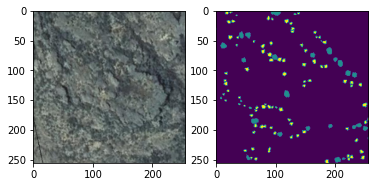

In [5]:
train_dataset_sa_low.show_tuple(1)

# 2. Model Training


In [6]:
from pytorch_segmentation.utils.sampling import create_weighted_dataset
from pytorch_segmentation.data.concat_dataset import ConcatDataset

train_dataset,weights = create_weighted_dataset([train_dataset_sa_low],weight=cfg["weight"])

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights),replacement=cfg["sampler_replacement"]) 

val_dataset = ConcatDataset([val_dataset_sa_low],shuffle=True)
#test_dataset = torch.utils.data.ConcatDataset([test_dataset_rw, test_dataset_sa])

In [7]:
if cfg["weighted"]:
    train_dl =DataLoader(train_dataset,sampler=sampler,batch_size=cfg["batch_size"],num_workers=cfg["nworkers"],shuffle=False,pin_memory=cfg["pin_memory"],
                      drop_last=True)
else:
    train_dl =DataLoader(train_dataset,batch_size=cfg["batch_size"],num_workers=cfg["nworkers"],shuffle=True,pin_memory=cfg["pin_memory"],
                  drop_last=True)

if (len(val_dataset) % cfg["batch_size"]) < cfg["nimgs"]:
    val_dl = DataLoader(val_dataset,batch_size=cfg["batch_size"],num_workers=cfg["nworkers"],
                     shuffle=False,pin_memory=cfg["pin_memory"],drop_last=True)
else:
    val_dl = DataLoader(val_dataset,batch_size=cfg["batch_size"],num_workers=cfg["nworkers"],
                         shuffle=False,pin_memory=cfg["pin_memory"],drop_last=False)
# test_dl = DataLoader(test_dataset,batch_size=batch_size,num_workers=nworkers,
#                      shuffle=False,pin_memory=pin_memory,drop_last=False)

## 2.2 Advanced Unet 
https://github.com/milesial/Pytorch-UNet

In [8]:
model_path = save_dir+"/unet_"+str(time.strftime("%d_%m_%Y_%H%M%S"))
# Change here to adapt to your data
net = UNet(n_channels=3, n_classes=2, bilinear=False,dropout=cfg["dropout"])

net= DataParallel(net,device_ids=[2])

net = net.to(device=device)


In [9]:
opt = torch.optim.Adam(net.parameters(),lr=cfg["lr"])
#opt = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=weight_decay)
if cfg["scheduler"]:
    scheduler = torch.optim.lr_scheduler.StepLR(opt, cfg["sched_step"],gamma=cfg["sched_gamma"]) #ReduceLROnPlateau(opt, 'max', patience=2) #S
else: 
    scheduler = None

In [ ]:
train_loss,valid_loss = train(net,train_dl,val_dl,cfg["loss_fn"],opt,cfg["epochs"],model_path=model_path+".pth",scheduler=scheduler,
                              scheduler_warmup=cfg["scheduler_warmup"],early_stopping=cfg["early_stopping"],
                              metric=cfg["metric"],tensorboard_path=cfg["tensorboard_path"],nimgs=cfg["nimgs"],figsize=cfg["figsize"],cfg=cfg,device=device,seed=seed)

INFO: Start run for unet_01_03_2023_141625!
Epoch 0/499
----------
train Loss: 0.3133 iou: 0.5891080694721863
valid Loss: 0.4009 iou: 0.7950664066499279
Epoch 1/499
----------
train Loss: 0.1573 iou: 0.9246739661994974
valid Loss: 0.2548 iou: 0.7862203742114144
Epoch 2/499
----------
train Loss: 0.1146 iou: 0.8819747933794752
valid Loss: 0.2057 iou: 0.8492692311981823
Epoch 3/499
----------
train Loss: 0.0872 iou: 0.8243778436310726
valid Loss: 0.1953 iou: 0.7670260457431569
Epoch 4/499
----------
train Loss: 0.0660 iou: 0.8308124742304229
valid Loss: 0.1859 iou: 0.8347646470766592
Epoch 5/499
----------
train Loss: 0.0552 iou: 0.8038281407061098
valid Loss: 0.1800 iou: 0.6686714491762744
Epoch 6/499
----------
train Loss: 0.0478 iou: 0.7936296521733923
valid Loss: 0.1691 iou: 0.7968241124496966
Epoch 7/499
----------
train Loss: 0.0420 iou: 0.7745724427980657
valid Loss: 0.1693 iou: 0.7673769498233325
Epoch 8/499
----------
train Loss: 0.0413 iou: 0.7894242710150525
valid Loss: 0.1766